# Forex Prediction using RNN

In [7]:

import pandas as pd

# Load the data from the CSV file
# Update the file_path to point to the location of your CSV file
file_path = 'euro_us.csv'
df = pd.read_csv(file_path)

# Convert 'Local time' to datetime format
df['Local time'] = pd.to_datetime(df['Local time'].str.split(" ", expand=True)[0])

# Check for missing values
missing_values = df.isnull().sum()
missing_values


/opt/homebrew/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '13.01.2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/opt/homebrew/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '14.01.2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/opt/homebrew/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '15.01.2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/opt/homebrew/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '16.01.2020' in DD/MM/YYYY format. Provide format or specify in

Local time    0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64

In [8]:

from sklearn.preprocessing import MinMaxScaler

# Select feature columns
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
features = df[feature_columns]

# Normalize the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Convert scaled features to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=feature_columns)
scaled_df.head()


Open      High       Low     Close  Volume
0  0.526889  0.525243  0.527878  0.526892     0.0
1  0.526889  0.525243  0.527878  0.526892     0.0
2  0.526889  0.525243  0.527878  0.526892     0.0
3  0.526889  0.525243  0.527878  0.526892     0.0
4  0.526889  0.525243  0.527878  0.526892     0.0

In [3]:

import numpy as np

def create_sequences(data, seq_length):
    sequences = []
    next_values = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        next_values.append(data[i+seq_length, 3])
     
    return np.array(sequences), np.array(next_values)

# Define sequence length
seq_length = 60

# Create sequences
sequences, next_values = create_sequences(scaled_features, seq_length)
sequences.shape, next_values.shape


((236763, 60, 5), (236763,))

In [4]:

import tensorflow as tf

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(seq_length, len(feature_columns))),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11200     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 51651 (201.76 KB)
Trainable params: 51651 (201.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:

# Split the data into training and validation sets
train_sequences = sequences[:200]
train_next_values = next_values[:200]
val_sequences = sequences[200:]
val_next_values = next_values[200:]

# Train the model
history = model.fit(
    train_sequences, train_next_values,
    epochs=7,
    batch_size=32,
    validation_data=(val_sequences, val_next_values)
)


Epoch 1/7
7/7 [==============================] - 58s 9s/step - loss: 0.1130 - val_loss: 0.0257
Epoch 2/7
7/7 [==============================] - 55s 9s/step - loss: 0.0116 - val_loss: 0.0374
Epoch 3/7
7/7 [==============================] - 55s 9s/step - loss: 0.0083 - val_loss: 0.0109
Epoch 4/7
7/7 [==============================] - 56s 9s/step - loss: 0.0032 - val_loss: 0.0120
Epoch 5/7
7/7 [==============================] - 57s 9s/step - loss: 6.6273e-04 - val_loss: 0.0193
Epoch 6/7
7/7 [==============================] - 58s 10s/step - loss: 6.6679e-04 - val_loss: 0.0134
Epoch 7/7
7/7 [==============================] - 55s 9s/step - loss: 4.1731e-04 - val_loss: 0.0144


In [6]:

# Evaluate the model
loss = model.evaluate(val_sequences, val_next_values)
loss


NameError: name 'model' is not defined

In [5]:

# Make predictions
predictions = model.predict(val_sequences)

# Reshape predictions and actual values
predictions = predictions.reshape(-1, 1)
val_next_values = val_next_values.reshape(-1, 1)

# Inverse transform using the new scaler
close_scaler = MinMaxScaler()
close_scaler.fit(df[['Close']])
inverse_predictions = close_scaler.inverse_transform(predictions)
inverse_actual = close_scaler.inverse_transform(val_next_values)


NameError: name 'model' is not defined

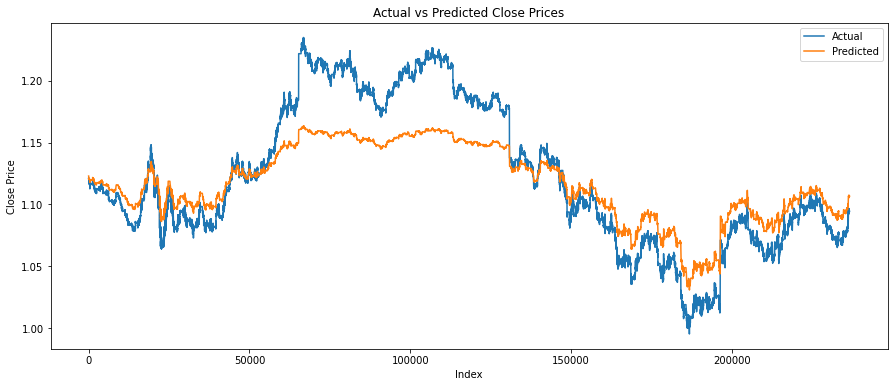

In [15]:
# Import the required libraries
import matplotlib.pyplot as plt
import numpy as np

# Convert to appropriate data types
inverse_actual = np.squeeze(inverse_actual)  # Remove unnecessary dimensions
inverse_predictions = np.squeeze(inverse_predictions)  # Remove unnecessary dimensions

# Generate the X-axis labels based on the length of the data
x_axis = np.arange(len(inverse_actual))

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(x_axis, inverse_actual, label='Actual')
plt.plot(x_axis, inverse_predictions, label='Predicted')

# Add labels and title
plt.legend()
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Index')
plt.ylabel('Close Price')

# Show the plot
plt.show()


In [16]:
import plotly.graph_objects as go

# Create a Plotly Figure
fig = go.Figure()

# Generate the X-axis labels based on the length of the data
x_axis = list(range(len(inverse_actual)))

# Add the actual close prices as a scatter plot
fig.add_trace(go.Scatter(x=x_axis, y=inverse_actual, mode='lines', name='Actual'))

# Add the predicted close prices as a scatter plot
fig.add_trace(go.Scatter(x=x_axis, y=inverse_predictions, mode='lines', name='Predicted'))

# Add title and labels
fig.update_layout(
    title='Actual vs Predicted Close Prices',
    xaxis=dict(title='Index'),
    yaxis=dict(title='Close Price')
)

# Show the plot
fig.show()


In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Prepare the data
x_axis = np.arange(len(inverse_actual))
inverse_actual = np.squeeze(inverse_actual)
inverse_predictions = np.squeeze(inverse_predictions)

# Initialize the plot
fig, ax = plt.subplots()
line1, = ax.plot([], [], lw=2, label='Actual')
line2, = ax.plot([], [], lw=2, label='Predicted')
ax.legend()
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')

# Initialize the data for the animation
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2,

# Update the data for the animation
def update(frame):
    line1.set_data(x_axis[:frame], inverse_actual[:frame])
    line2.set_data(x_axis[:frame], inverse_predictions[:frame])
    return line1, line2,

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=len(x_axis), init_func=init, blit=True)

plt.show()


NameError: name 'inverse_actual' is not defined